# Calculating bonding descriptors in diamond

![The structure of diamond with a single Wannier function plotted](images/structure.png)

This notebook demonstrates how `pengwann` can be used to compute bonding descriptors in a simple example system: diamond. More specifically, we will derive the Wannier orbital Hamilton population (WOHP) and Wannier orbital bond index (WOBI) for the C-C bond and integrate these quantities to (roughly speaking) measure the bond strength and bond order.

## Identifying interatomic interactions

Within `pengwann`, the interaction between atom A and atom B is the sum total of all interactions between the Wannier functions associated with atom A and the Wannier functions associated with atom B. In order to compute the WOHP or WOBI for the C-C bond in diamond, we must therefore first figure out which Wannier centres should be assigned to each carbon atom.

In [1]:
from pengwann.geometry import build_geometry

geometry = build_geometry(seedname='wannier90', path='inputs')
print(geometry)

Full Formula (X8 C2)
Reduced Formula: X4C
abc   :   2.517827   2.517827   2.517827
angles:  60.000000  60.000000  60.000000
pbc   :       True       True       True
Sites (10)
  #  SP            a          b          c  wannier_centres
---  ----  ---------  ---------  ---------  -----------------
  0  X0+    0.264244   0.578584  -0.421414  (8,)
  1  X0+    0.171416   0.485756   0.171415  (9,)
  2  X0+   -0.421414   0.264244   0.578584  (8,)
  3  X0+    0.485756   0.171414   0.171414  (9,)
  4  X0+    0.171415   0.171415   0.485756  (9,)
  5  X0+   -0.421415  -0.421415  -0.421414  (8,)
  6  X0+    0.578584  -0.421413   0.264244  (8,)
  7  X0+    0.171413   0.171416   0.171415  (9,)
  8  C      0.5        0.5        0.5       (0, 2, 5, 6)
  9  C      0.25       0.25       0.25      (1, 3, 4, 7)


Above, we have used the `build_geometry` function, which parses the Wannier90 seedname_centres.xyz and seedname.win files to extract the coordinates of atoms and Wannier centres as well as the cell vectors. A `pymatgen` `Structure` object is returned, which encapsulates the geometry of the system including periodic boundary conditions.

As well as providing a Python-compatible representation of the system's structure, the `build_geometry` function also assigns each Wannier centre to its closest atom. This is represented in the output above by the far righthand column labelled `wannier_centres`, within which each number is a site index referring to the order of atoms and Wannier centres within the `Structure` object. For example, looking at site #9 (the final site of the `Structure`), we see that its `wannier_centres` are `(1, 3, 4, 7)`, meaning that the Wannier centres at sites #1, #3, #4 and #7 have been assigned to/associated with this carbon atom. This assignment also goes both ways, in the sense that each Wannier centre (`X0+`) is associated with a single atom: looking at site #0, its `wannier_centres` are `(8,)`, meaning that this Wannier centre has been assigned to the carbon atom at site #8.

Note that the seedname_centres.xyz file read by `build_geometry` should always be generated in Wannier90 with `translate_home_cell = false`, If a seedname_centres.xyz file generated with `translate_home_cell = true` is used, then the Wannier centre assignments made by `build_geometry` will still be correct, but the interatomic interactions identified in subsequent steps **may not be accurate**.

Now that we have the geometry of the system and its Wannier centres available to us, we can identify interatomic interactions according to a radial distance cutoff:

In [2]:
from pengwann.geometry import identify_interatomic_interactions

# Find all C-C bonds that are < 1.6 Å.
cutoffs = {('C', 'C') : 1.6}

interactions = identify_interatomic_interactions(geometry, cutoffs)
print(interactions)

Atomic interactions
C8 <=> C9



Sure enough, because we are here using the primitive cell of diamond (which contains only 2 carbon atoms), we find only a single C-C interaction between sites #8 and #9 (with reference to the `Structure` object generated prior). The object returned by `identify_interatomic_interactions` is an `AtomicInteractionContainer`, which is a simple data structure that accommodates a series of individual `AtomicInteraction` objects:

In [3]:
for interaction in interactions:
    print(interaction)

Atomic interaction C8 <=> C9
DOS matrix => Not calculated
WOHP => Not calculated
WOBI => Not calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated
Charge => Not calculated


Associated Wannier interactions
-------------------------------
0[0, 0, 1] <=> 1[0, 0, 0]
0[0, 0, 1] <=> 3[0, 0, 0]
0[0, 0, 1] <=> 4[0, 0, 0]
0[0, 0, 1] <=> 7[0, 0, 0]
2[1, 0, 0] <=> 1[0, 0, 0]
2[1, 0, 0] <=> 3[0, 0, 0]
2[1, 0, 0] <=> 4[0, 0, 0]
2[1, 0, 0] <=> 7[0, 0, 0]
5[1, 1, 1] <=> 1[0, 0, 0]
5[1, 1, 1] <=> 3[0, 0, 0]
5[1, 1, 1] <=> 4[0, 0, 0]
5[1, 1, 1] <=> 7[0, 0, 0]
6[0, 1, 0] <=> 1[0, 0, 0]
6[0, 1, 0] <=> 3[0, 0, 0]
6[0, 1, 0] <=> 4[0, 0, 0]
6[0, 1, 0] <=> 7[0, 0, 0]



Here we can see that the interaction between `C8` and `C9` is internally represented by the interactions between their respective Wannier functions. The notation used to refer to each Wannier function can be understood as $\ket{w_{iR}} =$ `i[R_1, R_2, R_3]`, where `i` is a band-like index and `R_1`, `R_2` and `R_3` are the components of a Bravais lattice vector.

Just as an `AtomicInteractionContainer` can be iterated to access each individual `AtomicInteraction` object, each `AtomicInteraction` object can itself be iterated to yield individual `WannierInteraction` objects:

In [4]:
for interaction in interactions:
    for w_interaction in interaction:
        print(w_interaction)

Wannier interaction 0[0, 0, 1] <=> 1[0, 0, 0]
DOS matrix => Not calculated
H_ij => Not calculated
P_ij => Not calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated

Wannier interaction 0[0, 0, 1] <=> 3[0, 0, 0]
DOS matrix => Not calculated
H_ij => Not calculated
P_ij => Not calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated

Wannier interaction 0[0, 0, 1] <=> 4[0, 0, 0]
DOS matrix => Not calculated
H_ij => Not calculated
P_ij => Not calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated

Wannier interaction 0[0, 0, 1] <=> 7[0, 0, 0]
DOS matrix => Not calculated
H_ij => Not calculated
P_ij => Not calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated

Wannier interaction 2[1, 0, 0] <=> 1[0, 0, 0]
DOS matrix => Not calculated
H_ij => Not calculated
P_ij => Not calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated

Wanni

### Accessing specific interactions

As well as iterating over all `AtomicInteraction` objects associated with an `AtomicInteractionContainer`, or all of the `WannierInteraction` objects associated with an `AtomicInteraction`, one can also access specific interactions directly via numpy-style indexing with reference to the site indices in the previously generated `Structure` object:

In [5]:
print(interactions[8, 9])

Atomic interaction C8 <=> C9
DOS matrix => Not calculated
WOHP => Not calculated
WOBI => Not calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated
Charge => Not calculated


Associated Wannier interactions
-------------------------------
0[0, 0, 1] <=> 1[0, 0, 0]
0[0, 0, 1] <=> 3[0, 0, 0]
0[0, 0, 1] <=> 4[0, 0, 0]
0[0, 0, 1] <=> 7[0, 0, 0]
2[1, 0, 0] <=> 1[0, 0, 0]
2[1, 0, 0] <=> 3[0, 0, 0]
2[1, 0, 0] <=> 4[0, 0, 0]
2[1, 0, 0] <=> 7[0, 0, 0]
5[1, 1, 1] <=> 1[0, 0, 0]
5[1, 1, 1] <=> 3[0, 0, 0]
5[1, 1, 1] <=> 4[0, 0, 0]
5[1, 1, 1] <=> 7[0, 0, 0]
6[0, 1, 0] <=> 1[0, 0, 0]
6[0, 1, 0] <=> 3[0, 0, 0]
6[0, 1, 0] <=> 4[0, 0, 0]
6[0, 1, 0] <=> 7[0, 0, 0]



Here we have used indices `[8, 9]` to access the interaction between `C8` and `C9`. We can be even more specific and access a particular `WannierInteraction` associated with the overall `AtomicInteraction`:

In [6]:
print(interactions[8, 9][0, 1])

Wannier interaction 0[0, 0, 1] <=> 1[0, 0, 0]
DOS matrix => Not calculated
H_ij => Not calculated
P_ij => Not calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated



Note that the order of indices does not matter, we could rewrite the above as:

In [7]:
print(interactions[9, 8][1, 0])

Wannier interaction 0[0, 0, 1] <=> 1[0, 0, 0]
DOS matrix => Not calculated
H_ij => Not calculated
P_ij => Not calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated



Finally, rather than specifying a specific `AtomicInteraction` or `WannierInteraction` by providing 2 indices, we can also use a single index to retrieve all interactions involving a particular atom or Wannier function. For example, to access all `WannierInteractions` between the Wannier function at site #0 and any other Wannier function:

In [8]:
for w_interaction in interactions[8, 9][0]:
    print(w_interaction)

Wannier interaction 0[0, 0, 1] <=> 1[0, 0, 0]
DOS matrix => Not calculated
H_ij => Not calculated
P_ij => Not calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated

Wannier interaction 0[0, 0, 1] <=> 3[0, 0, 0]
DOS matrix => Not calculated
H_ij => Not calculated
P_ij => Not calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated

Wannier interaction 0[0, 0, 1] <=> 4[0, 0, 0]
DOS matrix => Not calculated
H_ij => Not calculated
P_ij => Not calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated

Wannier interaction 0[0, 0, 1] <=> 7[0, 0, 0]
DOS matrix => Not calculated
H_ij => Not calculated
P_ij => Not calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated



## Calculating the WOHP and the WOBI

To actually calculate the WOHP and the WOBI for the C-C bond, we will need to parse a few more Wannier90 input and output files. This can be easily accomplished with the `read` function, which parses the Wannier90 seedname.eig, seedname_u.mat and seedname_hr.dat files to yield the k-point mesh, the Kohn-Sham eigenvalues, the unitary matrices that define the Wannier functions and the Wannier Hamiltonian:

In [9]:
from pengwann.io import read

kpoints, eigenvalues, u_matrices, hamiltonian = read(seedname='wannier90',
                                                     path='inputs')

If we only wanted to calculate the WOHP, we would now have all the data required to proceed, but in the case of the WOBI, we are also in need of the ab initio occupation matrix (required to compute elements of the Wannier density matrix). Ideally, the occupation matrix should be read directly from the output of the ab intio code, in our case from VASP. Due to the fact that different ab initio codes output the occupation matrix in different formats, `pengwann` does not provide a generic IO function for this purpose. We recommend in general that users look towards other larger and more general-use Python packages such as `pymatgen` or `ase` for this functionality, and use these to read the occupation matrix from their ab initio calculations.

If for whatever reason the occupation matrix cannot be read directly from the ab intio code, then the `get_occupation_matrix` function can be used to reconstruct it from the Kohn-Sham eigenvalues:

In [10]:
from pengwann.occupations import get_occupation_matrix

mu = 9.9185 # The Fermi level
nspin = 2 # The number of electrons per fully-occupied state.

occupation_matrix = get_occupation_matrix(eigenvalues, mu, nspin)

By default, the `get_occupation_matrix` function uses a heaviside function to build the occupation matrix: occupation numbers are 1 below the Fermi level and 0 above it (with a sharp cutoff). In the case of diamond, an insulator, this is perfectly appropriate, but for systems in which thermal smearing has been applied during the ab initio calculation it may be desirable to apply a different occupation function. The `get_occupation_matrix` function has an optional `occupation_function` keyword argument that can be used to apply any arbitary occupation function.

The actual calculation of bonding descriptors is accomplished in `pengwann` via the `DescriptorCalculator` class. To initialise this class, we need to specify a few more parameters:

In [11]:
num_wann = 8
energy_range = (-15, 25)
resolution = 0.1
sigma = 0.2 # Smearing width for the DOS

Note that the `energy_range`, `resolution` and `sigma` variables all refer to the manner in which the density of states is to be evaluated: from `energy_range[0]` to `energy_range[1]` in steps of `resolution`, smeared by a Gaussian of width `sigma`.

In [12]:
from pengwann.descriptors import DescriptorCalculator

dcalc = DescriptorCalculator.from_eigenvalues(eigenvalues,
                                              num_wann, 
                                              nspin, 
                                              energy_range, 
                                              resolution, 
                                              sigma, 
                                              kpoints, 
                                              u_matrices, 
                                              hamiltonian,
                                              occupation_matrix)

Having initialised a `DescriptorCalculator`, actually calculating the WOHP and the WOBI is very straightforward:

In [13]:
interactions = dcalc.assign_descriptors(interactions)

  0%|          | 0/16 [00:00<?, ?it/s]

Note that the `assign_descriptors` method returns a new instance of the input `interactions` rather than updating it in-place - this is true of the vast majority of methods and functions in `pengwann`.

In [14]:
for interaction in interactions:
    print(interaction)

Atomic interaction C8 <=> C9
DOS matrix => Calculated
WOHP => Calculated
WOBI => Calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated
Charge => Not calculated


Associated Wannier interactions
-------------------------------
0[0, 0, 1] <=> 1[0, 0, 0]
0[0, 0, 1] <=> 3[0, 0, 0]
0[0, 0, 1] <=> 4[0, 0, 0]
0[0, 0, 1] <=> 7[0, 0, 0]
2[1, 0, 0] <=> 1[0, 0, 0]
2[1, 0, 0] <=> 3[0, 0, 0]
2[1, 0, 0] <=> 4[0, 0, 0]
2[1, 0, 0] <=> 7[0, 0, 0]
5[1, 1, 1] <=> 1[0, 0, 0]
5[1, 1, 1] <=> 3[0, 0, 0]
5[1, 1, 1] <=> 4[0, 0, 0]
5[1, 1, 1] <=> 7[0, 0, 0]
6[0, 1, 0] <=> 1[0, 0, 0]
6[0, 1, 0] <=> 3[0, 0, 0]
6[0, 1, 0] <=> 4[0, 0, 0]
6[0, 1, 0] <=> 7[0, 0, 0]



As seen above, the DOS matrix, WOHP and WOBI are now reported as `Calculated`. Similarly, if we dig into the individual `WannierInteraction` objects, we find that these too have been updated:

In [15]:
for interaction in interactions:
    for w_interaction in interaction:
        print(w_interaction)

Wannier interaction 0[0, 0, 1] <=> 1[0, 0, 0]
DOS matrix => Calculated
H_ij => -3.564015
P_ij => 0.2635638912672347
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated

Wannier interaction 0[0, 0, 1] <=> 3[0, 0, 0]
DOS matrix => Calculated
H_ij => -1.373425
P_ij => 0.13077167009414717
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated

Wannier interaction 0[0, 0, 1] <=> 4[0, 0, 0]
DOS matrix => Calculated
H_ij => -3.564021
P_ij => 0.26356361768674297
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated

Wannier interaction 0[0, 0, 1] <=> 7[0, 0, 0]
DOS matrix => Calculated
H_ij => 1.764448
P_ij => -0.23212541971650075
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated

Wannier interaction 2[1, 0, 0] <=> 1[0, 0, 0]
DOS matrix => Calculated
H_ij => -1.373513
P_ij => 0.13077987161014826
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated

Wannier interaction 2[1, 0

As shown above, the integrals of the DOS matrix, WOHP and WOBI are not computed automatically when the `assign_descriptors` method is called. To obtain these values, we use the `with_integrals` method:

In [16]:
interactions = interactions.with_integrals(dcalc.energies,
                                           mu, 
                                           resolve_orbitals=True)

for interaction in interactions:
    print(interaction)

Atomic interaction C8 <=> C9
DOS matrix => Calculated
WOHP => Calculated
WOBI => Calculated
IWOHP => Calculated
IWOBI => Calculated
Population => Calculated
Charge => Not calculated


Associated Wannier interactions
-------------------------------
0[0, 0, 1] <=> 1[0, 0, 0]
0[0, 0, 1] <=> 3[0, 0, 0]
0[0, 0, 1] <=> 4[0, 0, 0]
0[0, 0, 1] <=> 7[0, 0, 0]
2[1, 0, 0] <=> 1[0, 0, 0]
2[1, 0, 0] <=> 3[0, 0, 0]
2[1, 0, 0] <=> 4[0, 0, 0]
2[1, 0, 0] <=> 7[0, 0, 0]
5[1, 1, 1] <=> 1[0, 0, 0]
5[1, 1, 1] <=> 3[0, 0, 0]
5[1, 1, 1] <=> 4[0, 0, 0]
5[1, 1, 1] <=> 7[0, 0, 0]
6[0, 1, 0] <=> 1[0, 0, 0]
6[0, 1, 0] <=> 3[0, 0, 0]
6[0, 1, 0] <=> 4[0, 0, 0]
6[0, 1, 0] <=> 7[0, 0, 0]



Note the use of the `resolve_orbitals` keyword argument, which ensures that the descriptors are integrated not only for the overall interaction between `C8` and `C9`, but also for each individual `WannierInteraction`:

In [17]:
for interaction in interactions:
    for w_interaction in interaction:
        print(w_interaction)

Wannier interaction 0[0, 0, 1] <=> 1[0, 0, 0]
DOS matrix => Calculated
H_ij => -3.564015
P_ij => 0.2635638912672347
IWOHP => Calculated
IWOBI => Calculated
Population => Calculated

Wannier interaction 0[0, 0, 1] <=> 3[0, 0, 0]
DOS matrix => Calculated
H_ij => -1.373425
P_ij => 0.13077167009414717
IWOHP => Calculated
IWOBI => Calculated
Population => Calculated

Wannier interaction 0[0, 0, 1] <=> 4[0, 0, 0]
DOS matrix => Calculated
H_ij => -3.564021
P_ij => 0.26356361768674297
IWOHP => Calculated
IWOBI => Calculated
Population => Calculated

Wannier interaction 0[0, 0, 1] <=> 7[0, 0, 0]
DOS matrix => Calculated
H_ij => 1.764448
P_ij => -0.23212541971650075
IWOHP => Calculated
IWOBI => Calculated
Population => Calculated

Wannier interaction 2[1, 0, 0] <=> 1[0, 0, 0]
DOS matrix => Calculated
H_ij => -1.373513
P_ij => 0.13077987161014826
IWOHP => Calculated
IWOBI => Calculated
Population => Calculated

Wannier interaction 2[1, 0, 0] <=> 3[0, 0, 0]
DOS matrix => Calculated
H_ij => -3.5640

Now that we have calculated the WOHP/WOBI and their integrated counterparts, we can plot these using `matplotlib`:

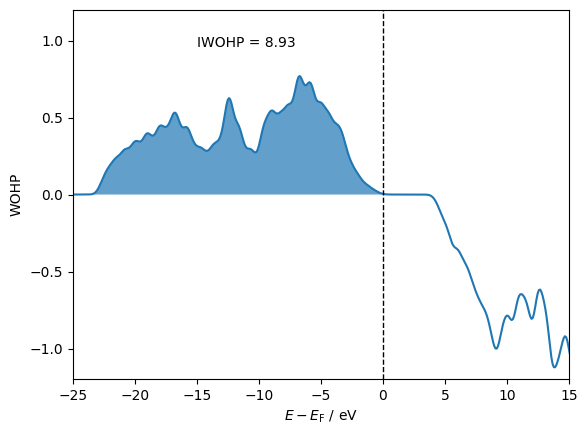

In [18]:
import matplotlib.pyplot as plt

shifted_energies = dcalc.energies - mu

wohp = interactions[8, 9].wohp
iwohp = interactions[8, 9].iwohp

fig, ax = plt.subplots()

ax.plot(shifted_energies, wohp)
ax.fill_between(shifted_energies, wohp, alpha=0.7, where=shifted_energies < 0)
ax.axvline(x=0, color='black', ls='--', lw=1)

ax.annotate(f'IWOHP = {iwohp:.2f}', (0.25, 0.90), xycoords='axes fraction')

ax.set_xlim(-25, 15)
ax.set_ylim(-1.2, 1.2)

ax.set_xlabel(r'$E - E_{\mathrm{F}}$ / eV')
ax.set_ylabel('WOHP')

plt.show()

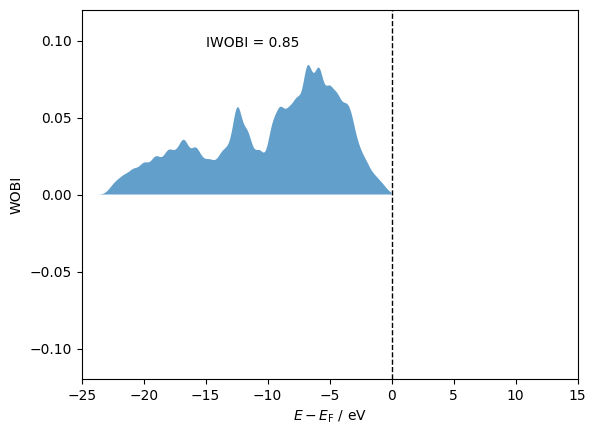

In [19]:
wobi = interactions[8, 9].wobi
iwobi = interactions[8, 9].iwobi

fig, ax = plt.subplots()

ax.fill_between(shifted_energies, wobi, alpha=0.7, where=shifted_energies < 0)
ax.axvline(x=0, color='black', ls='--', lw=1)

ax.annotate(f'IWOBI = {iwobi:.2f}', (0.25, 0.90), xycoords='axes fraction')

ax.set_xlim(-25, 15)
ax.set_ylim(-0.12, 0.12)

ax.set_xlabel(r'$E - E_{\mathrm{F}}$ / eV')
ax.set_ylabel('WOBI')

plt.show()

We can just as easily plot the WOHP and WOBI for a specific set of `WannierInteraction` objects:

0[0, 0, 1] <=> 1[0, 0, 0] IWOHP = 0.94
0[0, 0, 1] <=> 3[0, 0, 0] IWOHP = 0.18
0[0, 0, 1] <=> 4[0, 0, 0] IWOHP = 0.94
0[0, 0, 1] <=> 7[0, 0, 0] IWOHP = 0.41


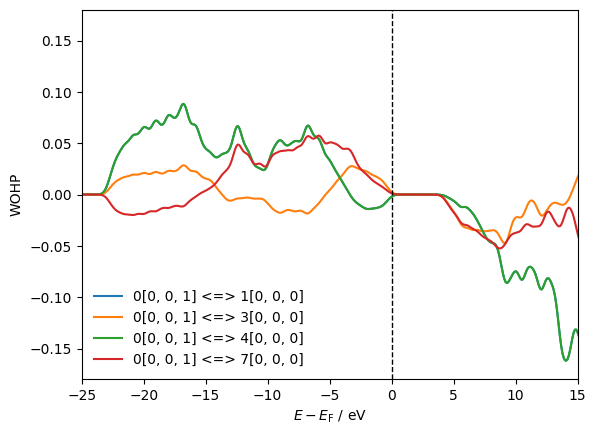

In [20]:
fig, ax = plt.subplots()

for w_interaction in interactions[8, 9][0]:
    ax.plot(shifted_energies, w_interaction.wohp, label=w_interaction.tag)
    print(f"{w_interaction.tag} IWOHP = {w_interaction.iwohp:.2f}")

ax.axvline(x=0, color='black', ls='--', lw=1)

ax.set_xlim(-25, 15)
ax.set_ylim(-0.18, 0.18)

ax.set_xlabel(r'$E - E_{\mathrm{F}}$ / eV')
ax.set_ylabel('WOHP')

ax.legend(frameon=False)

plt.show()

0[0, 0, 1] <=> 1[0, 0, 0] IWOBI = 0.07
0[0, 0, 1] <=> 3[0, 0, 0] IWOBI = 0.02
0[0, 0, 1] <=> 4[0, 0, 0] IWOBI = 0.07
0[0, 0, 1] <=> 7[0, 0, 0] IWOBI = 0.05


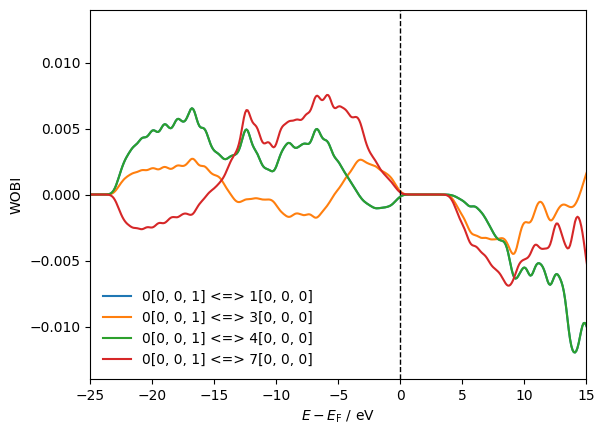

In [21]:
fig, ax = plt.subplots()

for w_interaction in interactions[8, 9][0]:
    ax.plot(shifted_energies, w_interaction.wobi, label=w_interaction.tag)
    print(f"{w_interaction.tag} IWOBI = {w_interaction.iwobi:.2f}")

ax.axvline(x=0, color='black', ls='--', lw=1)

ax.set_xlim(-25, 15)
ax.set_ylim(-0.014, 0.014)

ax.set_xlabel(r'$E - E_{\mathrm{F}}$ / eV')
ax.set_ylabel('WOBI')

ax.legend(frameon=False)

plt.show()

Note that in both of the plots above, the WOHP/WOBI arising from the interaction between Wannier functions `0[0, 0, 1]` and `1[0, 0, 0]` (blue line) is not visible because it is overlapped almost exactly by the interaction between Wannier functions `0[0, 0, 1]` and `4[0, 0, 0]` (green line).